In [1]:
import pickle as p
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import tensorflow_addons as tfa
import os, time, copy, math
from glob import glob
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
from random import seed, shuffle
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from skimage.color import gray2rgb
from tqdm import tqdm, trange
from sklearn.model_selection import train_test_split
from utils.myutils import *
from utils.gcnutils import *

import tf_geometric as tfg
from tf_geometric.utils import tf_utils
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten,Reshape, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPool2D, Concatenate
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 设置TensorFlow的日志级别为2，只显示error和warining信息

from tensorflow.keras import Model
from tensorflow.keras.models import load_model
%matplotlib inline


/root/miniconda3/envs/myconda/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/root/miniconda3/envs/myconda/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue

In [3]:
data_path = "./data/slices60/"  # 数据路径
model_path = "./model/VIT/"  # 设置模型保存目录
for path in [model_path]:
    print(path)
    if not os.path.exists(path):
        os.makedirs(path)

./model/VIT/


# 1.读入GCN数据表

In [4]:
# 读入结节信息
dat  = pd.read_csv("/mnt/GCNxin/data/是否微乳头_GNN.csv",encoding = 'utf-8')
dat.sort_values(by=["nID","ID","Z"], ascending=[True, True, True], inplace=True)  # 按结节nID，病人ID，Z轴升序排列
dat

,ID,X,Y,Z,lung,position,Image.type,Pathology,病理分级,Size.cm.,...,脉管瘤栓,淋巴结转移,flag_1,flag_2,flag_3,flag,Zrange,Zmed,slices,nID
0,7,157,222,241,右肺,中叶,纯磨玻璃,MIA,NaN,1.5,...,NaN,NaN,0,0,0,0,"[241, 256]",248,16,0
1,7,157,222,242,右肺,中叶,纯磨玻璃,MIA,NaN,1.5,...,NaN,NaN,0,0,0,0,"[241, 256]",248,16,0
2,7,157,222,243,右肺,中叶,纯磨玻璃,MIA,NaN,1.5,...,NaN,NaN,0,0,0,0,"[241, 256]",248,16,0
3,7,157,222,244,右肺,中叶,纯磨玻璃,MIA,NaN,1.5,...,NaN,NaN,0,0,0,0,"[241, 256]",248,16,0
4,7,157,222,245,右肺,中叶,纯磨玻璃,MIA,NaN,1.5,...,NaN,NaN,0,0,0,0,"[241, 256]",248,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10858,635,165,156,183,右肺,中叶,部分实性,腺癌,1.0,1.2,...,无,无,0,0,0,0,"[178, 187]",182,10,482
10859,635,165,156,184,右肺,中叶,部分实性,腺癌,1.0,1.2,...,无,无,0,0,0,0,"[178, 187]",182,10,482
10860,635,165,156,185,右肺,中叶,部分实性,腺癌,1.0,1.2,...,无,无,0,0,0,0,"[178, 187]",182,10,482
10861,635,165,156,186,右肺,中叶,部分实性,腺癌,1.0,1.2,...,无,无,0,0,0,0,"[178, 187]",182,10,482


# 2.划分训练集、验证集、测试集
#### 复现VGG16+CBAM的划分情况

In [5]:
IDs = pd.read_csv("/mnt/GCNxin/output.csv", encoding = 'utf-8', low_memory=False)
IDs

,train_IDs,valid_IDs,test_IDs
0,98,63.0,191.0
1,626,268.0,543.0
2,589,380.0,177.0
3,454,183.0,267.0
4,231,375.0,540.0
...,...,...,...
250,173,NaN,NaN
251,436,NaN,NaN
252,595,NaN,NaN
253,621,NaN,NaN


In [6]:
train_IDs_list = IDs['train_IDs'].dropna().astype(int).tolist() #将病人ID删除缺失值后以整数型数据保存为列表
test_IDs_list = IDs['test_IDs'].dropna().astype(int).tolist()
valid_IDs_list = IDs['valid_IDs'].dropna().astype(int).tolist()
train_IDs_listzong=train_IDs_list+valid_IDs_list # 获取训练集和验证集病人ID序列和
print(train_IDs_list)
print(test_IDs_list)
print(valid_IDs_list)
# 提取符合条件的切片，即 dat_cut DataFrame 中 ID 列属于 train_IDs_list 的切片
#train_slices = dat_cut[dat_cut['ID'].isin(train_IDs_list)]
#train_slices.reset_index(drop=True, inplace=True)
type(test_IDs_list)
len(train_IDs_listzong)

[98, 626, 589, 454, 231, 230, 119, 163, 568, 398, 461, 404, 444, 84, 284, 549, 574, 627, 562, 27, 312, 85, 510, 339, 203, 414, 580, 297, 519, 498, 400, 132, 298, 350, 402, 176, 430, 317, 114, 555, 167, 250, 333, 448, 55, 458, 281, 480, 272, 26, 277, 289, 299, 417, 296, 547, 566, 603, 273, 438, 354, 346, 386, 31, 511, 429, 310, 201, 550, 325, 295, 393, 249, 142, 171, 168, 399, 150, 185, 453, 258, 44, 366, 77, 497, 136, 394, 565, 587, 321, 349, 373, 304, 33, 66, 504, 544, 396, 523, 356, 599, 293, 209, 324, 329, 248, 166, 413, 422, 487, 144, 408, 336, 83, 90, 237, 22, 484, 631, 303, 502, 241, 216, 331, 283, 145, 632, 48, 246, 431, 172, 121, 35, 623, 184, 53, 598, 614, 352, 327, 579, 462, 360, 158, 219, 467, 612, 611, 357, 501, 524, 180, 575, 178, 68, 42, 266, 337, 343, 30, 622, 456, 530, 538, 29, 397, 257, 577, 139, 76, 286, 583, 131, 236, 395, 443, 18, 122, 368, 234, 425, 529, 221, 170, 433, 164, 481, 88, 572, 213, 592, 243, 278, 37, 32, 548, 485, 308, 154, 56, 471, 188, 156, 316, 446, 3

340

In [7]:
def psplitDF8(data, col_name, reset, train_IDs, test_IDs, seed=123, shuffle=False):
    # 得到两个数据集
    train_dat = data.loc[data[col_name].isin(train_IDs), ]  # 训练集
    test_dat = data.loc[data[col_name].isin(test_IDs), ]  # 测试集
    if reset == True:  # 判断是在划分训练集和测试集，还是在划分训练集和验证集
        train_dat = train_dat.reset_index(drop=True)  # 重设索引为连续的整数，从0开始
        test_dat = test_dat.reset_index(drop=True)
        train_index = list(range(len(train_dat)))  # 更新 train_index，使用range函数生成从0开始的连续整数序列
        test_index = list(range(len(test_dat)))  # 更新 test_index，使用range函数生成从0开始的连续整数序列
    else:
        # 提取索引，用于模型训练
        train_index = train_dat.index.tolist()  # 训练集索引
        test_index = test_dat.index.tolist()  # 测试集索引
    # 返回训练集表、测试集表、训练集表索引、测试集表索引
    return train_dat, test_dat, train_index, test_index

In [8]:
train_dat, test_dat, _, test_index = psplitDF8(dat, "ID",  train_IDs=train_IDs_listzong,test_IDs= test_IDs_list, reset=True)  # 按病人ID划分为训练集和测试集
len(train_dat)
train_datz, valid_dat, train_index, valid_index = psplitDF8(train_dat, "ID", train_IDs=train_IDs_list,test_IDs= valid_IDs_list,reset=False)  # 按病人ID将训练集再划分为训练集和验证集

print(f"训练数据中训练集{pcalRate(train_dat, train_index)}")
print(f"训练数据中验证集{pcalRate(train_dat, valid_index)}")
print(f"测试数据中测试集{pcalRate(test_dat, test_index)}")
print(f"训练集: {train_index[:5]}")
print(f"验证集: {valid_index[5]}")
print(f"测试集: {test_index}")
len(train_index)
len(valid_index)

训练数据中训练集切片数: 6578，微乳头切片占比: 38.81%，结节数: 291, 微乳头结节占比：31.2%，病人数: 255
训练数据中验证集切片数: 2278，微乳头切片占比: 34.77%，结节数: 99, 微乳头结节占比：31.0%，病人数: 85
测试数据中测试集切片数: 2007，微乳头切片占比: 40.01%，结节数: 93, 微乳头结节占比：28.35%，病人数: 86
训练集: [34, 35, 36, 37, 38]
验证集: 5
测试集: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174

2278

In [9]:
train_datz

,ID,X,Y,Z,lung,position,Image.type,Pathology,病理分级,Size.cm.,...,脉管瘤栓,淋巴结转移,flag_1,flag_2,flag_3,flag,Zrange,Zmed,slices,nID
34,18,195,336,182,右肺,下叶,纯实性,腺癌,3.0,3.3,...,无,无,1,1,1,1,"[182, 228]",205,47,5
35,18,195,336,183,右肺,下叶,纯实性,腺癌,3.0,3.3,...,无,无,1,1,1,1,"[182, 228]",205,47,5
36,18,195,336,184,右肺,下叶,纯实性,腺癌,3.0,3.3,...,无,无,1,1,1,1,"[182, 228]",205,47,5
37,18,195,336,185,右肺,下叶,纯实性,腺癌,3.0,3.3,...,无,无,1,1,1,1,"[182, 228]",205,47,5
38,18,195,336,186,右肺,下叶,纯实性,腺癌,3.0,3.3,...,无,无,1,1,1,1,"[182, 228]",205,47,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8841,632,293,291,24,左肺,上叶,纯实性,腺癌,3.0,1.3,...,有,无,1,1,0,1,"[15, 28]",21,14,481
8842,632,293,291,25,左肺,上叶,纯实性,腺癌,3.0,1.3,...,有,无,1,1,0,1,"[15, 28]",21,14,481
8843,632,293,291,26,左肺,上叶,纯实性,腺癌,3.0,1.3,...,有,无,1,1,0,1,"[15, 28]",21,14,481
8844,632,293,291,27,左肺,上叶,纯实性,腺癌,3.0,1.3,...,有,无,1,1,0,1,"[15, 28]",21,14,481


In [10]:
#得到各数据集无重复的ID值
tra_seq=train_datz["ID"].unique()
val_seq=valid_dat["ID"].unique()
tes_seq=test_dat["ID"].unique()
len(tes_seq)
print(tra_seq)
print(tes_seq)
print(len(tra_seq))
print(len(tes_seq))
print(len(val_seq))
tes_seq[0]

[ 18  20  22  26  27  29  30  31  32  33  35  37  42  44  48  53  55  56
  60  64  66  68  76  77  83  84  85  88  90  95  98 100 101 104 111 114
 119 121 122 127 131 132 136 139 142 144 145 147 150 154 156 158 159 163
 164 166 167 168 170 171 172 173 176 178 179 180 184 185 188 194 198 201
 203 209 213 216 219 221 222 223 230 231 234 236 237 241 243 244 246 248
 249 250 257 258 266 272 273 277 278 281 283 284 286 289 290 293 295 296
 297 298 299 303 304 308 310 312 316 317 321 324 325 327 328 329 331 332
 333 336 337 339 340 341 343 346 349 350 352 353 354 356 357 360 362 366
 368 373 386 387 390 393 394 395 396 397 398 399 400 402 404 408 413 414
 417 422 425 426 429 430 431 433 436 437 438 443 444 446 448 453 454 456
 458 461 462 467 471 472 474 480 481 482 484 485 487 493 496 497 498 501
 502 504 507 508 509 510 511 512 519 523 524 525 526 527 529 530 538 544
 545 547 548 549 550 555 562 563 564 565 566 568 572 574 575 576 577 579
 580 583 587 588 589 591 592 595 598 599 603 611 61

7

In [11]:
tra_image = []
val_image = []
tes_image = []

# 获取所有结节文件路径，并按指定顺序排序
imagePaths = glob(data_path + "*/*flag_*.npy")
imagePaths.sort(key=lambda x: [int(x.split("nID_")[1].split(",")[0]), int(x.split("ID_")[1].split(",")[0])], reverse=False)

# 将tra_seq、val_seq和tes_seq转换为set
tra_seq_set = set(tra_seq)
val_seq_set = set(val_seq)
tes_seq_set = set(tes_seq)
##按照ID值划分训练集、验证集、测试集
for i, image_path in enumerate(imagePaths):
    x = image_path.split(" ID_")[1].split(",")[0]
    a = int(x)
    if a in tra_seq_set:
        tra_image.append(image_path)
    elif a in val_seq_set:
        val_image.append(image_path)
    elif a in tes_seq_set:
        tes_image.append(image_path)

print("Train Images:", len(tra_image))
print("Valid Images:", len(val_image))
print("Test Images:", len(tes_image))

Train Images: 6578
Valid Images: 2278
Test Images: 2007


#### 构建训练集y_train、测试集y_test和验证集y_valid的标签

In [12]:
#构建0-1y
y_train=[]
y_test=[]
y_valid=[]
for i in range(6578):
    file_path = trainSets[i][0]  # 获取文件路径
    c = int(file_path.split('flag_')[1].split(".")[0])#提取文件路径中的标签(0或1)并将其附加到列表 y_train
    y_train.append(c)
    
for i in range(2007):
    file_path = testSets[i][0]  # 获取文件路径
    c = int(file_path.split('flag_')[1].split(".")[0])
    y_test.append(c)
    
for i in range(2278):
    file_path = validSets[i][0]  # 获取文件路径
    c = int(file_path.split('flag_')[1].split(".")[0])
    y_valid.append(c)  

#print(y_test)
type(y_test)
y_train=np.array(y_train)
type(y_train)
y_test=np.array(y_test)
type(y_test)
y_test.shape
type(y_valid)
y_valid=np.array(y_valid)
y_valid.shape


(2278,)

In [14]:
y_train.shape
y_train=list(y_train)
y_train=np.array(y_train)
y_train.resize((6578, 1))#调整y_train数组的形状为(6578, 1)
print(y_train)
y_test=list(y_test)
y_test=np.array(y_test)
y_test.resize((2007, 1))#调整y_test数组的形状为(2007, 1)
y_valid=list(y_valid)
y_valid=np.array(y_valid)
y_valid.resize((2278, 1))#调整y_valid数组的形状为(2278, 1)

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


numpy.ndarray

In [16]:
#计算测试集中微乳头切片的数量
count2=0
for i in range(2007):
    if y_test[i]==1:
        count2=count2+1
print(count2)

803


In [17]:
#计算验证集中微乳头切片的数量
count3=0
for i in range(2278):
    if y_valid[i]==1:
        count3=count3+1
print(count3)

792


In [18]:
#计算训练集中微乳头切片的数量
count1=0
for i in range(6578):
    if y_train[i]==1:
        count1=count1+1
print(count1)

2553


#### 数据预处理（单通道转RGB三通道）

In [19]:
# 读取单个npy文件
def get_data_from_file(filePath):
    img_gray = np.load(filePath)  # 读取npy，[60,60]
    img_rgb = gray2rgb(img_gray)  # 第一种办法，灰度图转RGB，[60,60,3]
    #img_rgb = np.repeat(img_gray[..., np.newaxis], 1, -1)  # 第二种办法，单通道复制为3通道，[60,60,3]
    #print(tes_image[0].shape)
    #img_rgb=tf.image.resize(img_rgb, [32,32])
    #print(resized)
    return img_rgb

# 遍历列表，读取多个npy文件，组合成一个batch
def combineBatch(paths):
    batch_data = []
    for path in paths:
        batch_data.append(get_data_from_file(path))
    return np.asarray(batch_data)  # [B,H,W,C]

#### 将切片数据分batch输入模型，得到各切片的featuremap，最后可以构成特征矩阵

In [20]:
#训练
features1 = []
batchsize = 50  # 每个batch的数据量
N = len(tra_image)  # 样本总数
batchs = N // batchsize  # 分多少个batch计算
for ibatch in trange(batchs):  # 遍历每个整数batch
    batchPaths = tra_image[ibatch * batchsize: (ibatch+1) * batchsize]  # 数据路径切片
    batchData = combineBatch(batchPaths)  # 组合batch数据
    features1.append(batchData)
batchPaths = imagePaths[(ibatch+1) * batchsize: N]  # 数据路径切片
batchData = combineBatch(batchPaths)  # 组合batch数据
features1.append(batchData)  # 存储featuremap
features1 = np.vstack(features1)

features1.shape

100%|██████████| 131/131 [00:20<00:00,  6.54it/s]


(6578, 60, 60, 3)

In [21]:
#验证
features3 = []
batchsize = 50  # 每个batch的数据量
N = len(val_image)  # 样本总数
batchs = N // batchsize  # 分多少个batch计算
for ibatch in trange(batchs):  # 遍历每个整数batch
    batchPaths = val_image[ibatch * batchsize: (ibatch+1) * batchsize]  # 数据路径切片
    batchData = combineBatch(batchPaths)  # 组合batch数据
    features3.append(batchData)
batchPaths = imagePaths[(ibatch+1) * batchsize: N]  # 数据路径切片
batchData = combineBatch(batchPaths)  # 组合batch数据
features3.append(batchData)  # 存储featuremap
features3 = np.vstack(features3)

features3.shape

100%|██████████| 45/45 [00:07<00:00,  6.42it/s]


(2278, 60, 60, 3)

In [22]:
#测试
features2 = []
batchsize = 40  # 每个batch的数据量
N = len(tes_image)  # 样本总数
batchs = N // batchsize  # 分多少个batch计算
for ibatch in trange(batchs):  # 遍历每个整数batch
    batchPaths = tes_image[ibatch * batchsize: (ibatch+1) * batchsize]  # 数据路径切片
    batchData = combineBatch(batchPaths)  # 组合batch数据
    features2.append(batchData)
batchPaths = imagePaths[(ibatch+1) * batchsize: N]  # 数据路径切片
batchData = combineBatch(batchPaths)  # 组合batch数据
features2.append(batchData)  # 存储featuremap
features2 = np.vstack(features2)

features2.shape

100%|██████████| 50/50 [00:06<00:00,  7.57it/s]


(2007, 60, 60, 3)

# 3.构建VIT模型

In [23]:
num_classes = 1 #二分类任务，问题类别数量设置为1
input_shape = (60, 60, 3)
#定义训练超参数
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 50
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2 #图像块总数量
projection_dim = 64
num_heads = 4
#定义 Transformer 层的单元大小
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8 #模型中Transformer 层的数量。
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [24]:
#数据增强
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(features1)

In [25]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [26]:
#从图像中提取patch
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

    def get_config(self):
        return {'patch_size': self.patch_size}


In [28]:
#对图像的每个patch进行编码
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        #一个全连接层，其输出维度为projection_dim，没有指明激活函数
        self.projection = layers.Dense(units=projection_dim)
        #定义一个嵌入层，这是一个可学习的层
        #输入维度为num_patches，输出维度为projection_dim
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
 
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded
    def get_config(self):
        config = super(PatchEncoder, self).get_config()
        config.update({
            'num_patches': self.num_patches,
            'projection_dim': self.projection.units,  # 获取 Dense 层的输出维度
        })
        return config #返回配置信息

In [29]:
#定义Vision Transformer（ViT）结构
def create_vit_classifier():
    #input_shape = (60, 60, 3)
    #inputs = layers.Input(shape=input_shape)
    inputs=keras.Input(shape=(60, 60, 3))
    # Augment data.
    augmented = data_augmentation(inputs)
    #augmented = inputs
    #augmented = augmented_train_batches(inputs)    
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
 
    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])
 
    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    features=Reshape((1,1,1024), name='features_reshape')(features)
    # Channel Attention
    avgpool = GlobalAveragePooling2D(name='channel_avgpool')(features)
    maxpool = GlobalMaxPool2D(name='channel_maxpool')(features)
# Shared MLP
    Dense_layer1 = Dense(1024//32,activation='relu', name='channel_fc1')
    Dense_layer2 = Dense(1024, activation='relu', name='channel_fc2')
    avg_out = Dense_layer2(Dense_layer1(avgpool))
    max_out = Dense_layer2(Dense_layer1(maxpool))

    channel = layers.add([avg_out, max_out])
    channel = Activation('sigmoid', name='channel_sigmoid')(channel)
    channel = Reshape((1,1,1024), name='channel_reshape')(channel)
    channel_out = tf.multiply(features, channel)
    
# Spatial Attention
    avgpool = tf.reduce_mean(channel_out, axis=3, keepdims=True, name='spatial_avgpool')
    maxpool = tf.reduce_max(channel_out, axis=3, keepdims=True, name='spatial_maxpool')
    spatial = Concatenate(axis=3)([avgpool, maxpool])

    spatial = Conv2D(1, (7,7), strides=1, padding='same',name='spatial_conv2d')(spatial)
    spatial_out = Activation('sigmoid', name='spatial_sigmoid')(spatial)
    spatial_out=BatchNormalization()(features)

    CBAM_out = tf.multiply(channel_out, spatial_out)
    features=CBAM_out
    
    # Classify outputs.
    features = keras.layers.GlobalAveragePooling2D()(features)
    logits = layers.Dense(num_classes)(features)
    
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [30]:
vit_classifier = create_vit_classifier()
vit_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 60, 3)]  0                                            
__________________________________________________________________________________________________
data_augmentation (Sequential)  (None, 72, 72, 3)    7           input_1[0][0]                    
__________________________________________________________________________________________________
patches_1 (Patches)             (None, None, 108)    0           data_augmentation[0][0]          
__________________________________________________________________________________________________
patch_encoder (PatchEncoder)    (None, 144, 64)      16192       patches_1[0][0]                  
______________________________________________________________________________________________

#### 模型编译与训练

In [32]:
%%time
optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
vit_classifier.compile(
        optimizer=optimizer,
        #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[keras.metrics.BinaryAccuracy()
        #metrics=[
        #    keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            #keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )
#optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              #loss=keras.losses.BinaryCrossentropy(from_logits=True),
              #metrics=[keras.metrics.BinaryAccuracy()

CPU times: user 14.9 ms, sys: 2.28 ms, total: 17.2 ms
Wall time: 14 ms


In [33]:
#checkpoint_filepath ="model_bak.hdf5"
train_start = time.strftime("%Y-%m-%d %H:%M:%S")
checkpoint_filepath =os.path.join(model_path, f'{train_start} vit_gcn_best.h5')
checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_binary_accuracy",
        save_best_only=True,
        save_weights_only=False,
    )
 

In [34]:
vit_classifier.fit(
        x=features1,
        y=y_train,
        batch_size=batch_size,
        epochs=10,
        validation_data=(features3, y_valid),
        callbacks=[checkpoint_callback],
        #callbacks=callback
    )

Epoch 1/10
132/132 [==============================] - 24s 101ms/step - loss: 2.1317 - binary_accuracy: 0.6323 - val_loss: 0.6410 - val_binary_accuracy: 0.6497


/root/miniconda3/envs/myconda/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/10
132/132 [==============================] - 12s 90ms/step - loss: 0.7469 - binary_accuracy: 0.6669 - val_loss: 0.6473 - val_binary_accuracy: 0.6462
Epoch 3/10
132/132 [==============================] - 12s 91ms/step - loss: 0.5803 - binary_accuracy: 0.7133 - val_loss: 0.6581 - val_binary_accuracy: 0.6576
Epoch 4/10
132/132 [==============================] - 12s 90ms/step - loss: 0.5506 - binary_accuracy: 0.7271 - val_loss: 0.6652 - val_binary_accuracy: 0.6475
Epoch 5/10
132/132 [==============================] - 12s 90ms/step - loss: 0.5261 - binary_accuracy: 0.7355 - val_loss: 0.6543 - val_binary_accuracy: 0.6510
Epoch 6/10
132/132 [==============================] - 12s 90ms/step - loss: 0.4965 - binary_accuracy: 0.7448 - val_loss: 0.7160 - val_binary_accuracy: 0.6501
Epoch 7/10
132/132 [==============================] - 12s 90ms/step - loss: 0.4916 - binary_accuracy: 0.7533 - val_loss: 0.6974 - val_binary_accuracy: 0.6374
Epoch 8/10
132/132 [==============================] 

#### 模型预测

In [35]:
result=vit_classifier.predict(features2)#对测试集进行模型预测
#pred = tf.argmax(result, axis=1)
print(result)

[[-1.0316936 ]
 [-0.87854105]
 [-0.9556446 ]
 ...
 [-0.12032406]
 [-0.3178721 ]
 [-0.12473962]]


In [37]:
#计算阈值，将预测结果转换为0或1
result.max()
result.min()
result.shape
a=result.min()+(result.max()-result.min())/2
result1=result.tolist() # 将预测结果转换为列表
type(result.tolist())
pred1={}
for i in range(2007):
    if result1[i]<=a:
        pred1[i]=0
    else:
        pred1[i]=1

-0.39454126358032227

In [40]:
#统计预测结果为1（微乳头）的数量
count=0
for i in range(2007):
    if pred1[i]==1:
        count=count+1
print(count)

1206


In [42]:
# 提取预测结果
#pred1=pred1.numpy()
pred1 = pred1.items()
# Convert object to a list
pred1= list(pred1) 
# Convert list to an array
pred1 = np.array(pred1) 
# print the numpy array
print(type(pred1))
#type(y_test)
print(type(result))
pred=pred1[:,1]
pred

<class 'numpy.ndarray'>


array([0, 0, 0, ..., 1, 1, 1])

# 4.模型评估

Confusion matrix, without normalization
[[707 497]
 [ 94 709]]


,ACC_pred,Specificity,Sensitivity,PPV,NPV,F1-Score,ACC_argmax,AUC
0,0.705531,0.587209,0.882939,0.587894,0.882647,0.705824,0.705531,0.818815


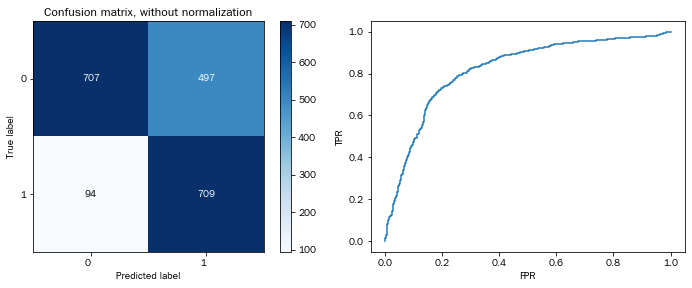

In [44]:
#切片层面
labels_value = np.array([0, 1])
tn, fp, fn, tp = confusion_matrix(y_test, pred, labels=labels_value).ravel() ##ravel数组维度拉成一维数组
    # Accuracy
acc1 = accuracy_score(y_test, pred)
#     print("Accuracy:{:.4f}".format(acc1))
    # 特异性：TN / N
specificity = tn / (tn+fp)
    # 敏感度：TP / P
sensitivity= tp/(tp+fn)
    # Positive predictive value PPV = TP / (TP + FP)
ppv = tp / (tp+fp)
    # Negative predictive value NPV = TN / (TN + FN)
npv = tn / (tn+fn)
    # F1-score
f1 = f1_score(y_test, pred) ##结果是类别1的score
acc2 = accuracy_score(y_test, pred)
    # ROC曲线
fpr, tpr, thresholds = roc_curve(y_test, result[:])
roc_auc = auc(fpr, tpr)
    # 最佳阈值
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
bestThresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]] ##argsort数组中的元素从小到大排序后的索引数组值
title = 'Confusion matrix, without normalization'
    # Compute confusion matrix
cm = confusion_matrix(y_test, pred)
    # Only use the labels that appear in the data
classes = labels_value[unique_labels(y_test, pred)]
print('Confusion matrix, without normalization')
print(cm)
#     fig, ax = plt.subplots()
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
        xticklabels=classes, yticklabels=classes,
        title=title,
        ylabel='True label',
        xlabel='Predicted label')

ax.set_ylim(len(classes)-0.5, -0.5)
    # Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")  
    # Loop over data dimensions and create text annotations.
fmt = 'd' 
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
    # 绘制ROC曲线
ax = fig.add_subplot(122)
ax.plot(fpr, tpr, label='ROC')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
    
    # 整合评估指标
metrics_s = pd.DataFrame({"ACC_pred": [acc1], "Specificity": [specificity], "Sensitivity": [sensitivity],
                            "PPV": [ppv], "NPV": [npv], "F1-Score": [f1], "ACC_argmax": [acc2], "AUC": [roc_auc]})
    
fig.tight_layout()
metrics_s


In [45]:
#计算结节层面的预测结果
pthresh=0.5
if test_index is None:
    noduleData = test_dat.loc[:, ["nID", "ID", "flag"]].copy()  # copy测试集原数据
else:
    noduleData = test_dat.loc[test_index, ["nID", "ID", "flag"]].copy()  # 复制测试集指定索引的数据
noduleData["y_pred"] = pred
noduleData["0_value"] = result
noduleData = noduleData.groupby("nID").mean()  # 平均法
noduleData[["ID","flag"]] = noduleData[["ID", "flag"]].astype(int)  # 保持数据类型
noduleData["voting_pred"] = noduleData["y_pred"].apply(lambda x: 1 if x > pthresh else 0)  # 投票法得到预测标签，90%阈值
#compreEval(noduleData["flag"], noduleData["voting_pred"], np.asarray(noduleData["0_value"]), classes=labels_value, normalize=False)

Confusion matrix, without normalization
[[45 22]
 [ 3 23]]


,ACC_pred,Specificity,Sensitivity,PPV,NPV,F1-Score,ACC_argmax,AUC
0,0.731183,0.671642,0.884615,0.511111,0.9375,0.647887,0.731183,0.818599


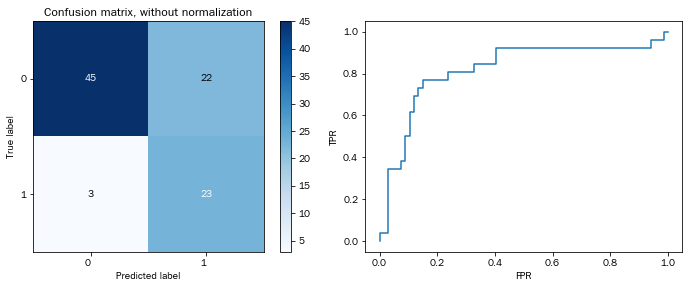

In [46]:
# 结节层面
tn, fp, fn, tp = confusion_matrix(noduleData["flag"], noduleData["voting_pred"], labels=labels_value).ravel() ##ravel数组维度拉成一维数组
    # Accuracy
acc1 = accuracy_score(noduleData["flag"], noduleData["voting_pred"])
#     print("Accuracy:{:.4f}".format(acc1))
    # 特异性：TN / N
specificity = tn / (tn+fp)
    # 敏感度：TP / P
sensitivity= tp/(tp+fn)
    # Positive predictive value PPV = TP / (TP + FP)
ppv = tp / (tp+fp)
    # Negative predictive value NPV = TN / (TN + FN)
npv = tn / (tn+fn)
    # F1-score
f1 = f1_score(noduleData["flag"], noduleData["voting_pred"]) ##结果是类别1的score
acc2 = accuracy_score(noduleData["flag"], noduleData["voting_pred"])
    # ROC曲线
fpr, tpr, thresholds = roc_curve(noduleData["flag"], np.asarray(noduleData["0_value"]))
roc_auc = auc(fpr, tpr)
    # 最佳阈值
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
bestThresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]] ##argsort数组中的元素从小到大排序后的索引数组值
title = 'Confusion matrix, without normalization'
    # Compute confusion matrix
cm = confusion_matrix(noduleData["flag"], noduleData["voting_pred"])
    # Only use the labels that appear in the data
classes = labels_value[unique_labels(noduleData["flag"], noduleData["voting_pred"])]
print('Confusion matrix, without normalization')
print(cm)
#     fig, ax = plt.subplots()
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
        xticklabels=classes, yticklabels=classes,
        title=title,
        ylabel='True label',
        xlabel='Predicted label')
ax.set_ylim(len(classes)-0.5, -0.5)
    # Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")  
    # Loop over data dimensions and create text annotations.
fmt = 'd' 
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
    # 绘制ROC曲线
ax = fig.add_subplot(122)
ax.plot(fpr, tpr, label='ROC')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
    # 整合评估指标
metrics_n = pd.DataFrame({"ACC_pred": [acc1], "Specificity": [specificity], "Sensitivity": [sensitivity],
                            "PPV": [ppv], "NPV": [npv], "F1-Score": [f1], "ACC_argmax": [acc2], "AUC": [roc_auc]})
fig.tight_layout()
metrics_n


In [46]:

metrics = pd.concat([metrics_s, metrics_n])
metrics.index = ["切片级","结节级"]
metrics

,ACC_pred,Specificity,Sensitivity,PPV,NPV,F1-Score,ACC_argmax,AUC
切片级,0.449427,0.109635,0.958904,0.418024,0.800000,0.582231,0.449427,0.780864
结节级,0.333333,0.104478,0.923077,0.285714,0.777778,0.436364,0.333333,0.769231


In [59]:
base_model=vit_classifier
featModel = Model(inputs=base_model.input, outputs=[base_model.layers[-2].output])
for layer in base_model.layers:
    layer.trainable = False  # 设置参数不可训练
featModel.summary(line_length=120)

Model: "model_1"
________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
input_1 (InputLayer)                   [(None, 60, 60, 3)]        0                                                     
________________________________________________________________________________________________________________________
data_augmentation (Sequential)         (None, 72, 72, 3)          7             input_1[0][0]                           
________________________________________________________________________________________________________________________
patches (Patches)                      (None, None, 108)          0             data_augmentation[0][0]                 
________________________________________________________________________________________________________________________
patch_encoder (

In [60]:
features = []  # 存储每个batch得到的featuremap
batchsize = 50  # 每个batch的数据量
N = len(imagePaths)  # 样本总数
batchs = N // batchsize  # 分多少个batch计算
for ibatch in trange(batchs):  # 遍历每个整数batch
    batchPaths = imagePaths[ibatch * batchsize: (ibatch+1) * batchsize]  # 数据路径切片
    batchData = combineBatch(batchPaths)  # 组合batch数据
    batchfeatures = featModel.predict(batchData)  # 计算featuremap
    features.append(batchfeatures)  # 存储featuremap
# 计算不足整个batch的末尾数据
batchPaths = imagePaths[(ibatch+1) * batchsize: N]  # 数据路径切片
batchData = combineBatch(batchPaths)  # 组合batch数据
batchfeatures = featModel.predict(batchData)  # 计算featuremap
features.append(batchfeatures)  # 存储featuremap
features = np.vstack(features)  # list转array，按第一维度堆叠list中的每个array
featuremap = pd.DataFrame(features)  # array转DataFrame
featuremap.shape

100%|██████████| 217/217 [01:03<00:00,  3.40it/s]


(10863, 1024)

In [61]:
featuremap.to_csv('/mnt/GCNxin/data/08病人是否微乳头featuremap_vit.csv', index = False, mode="w+")#实际为CA

In [62]:
datGCN = pd.concat([dat, featuremap], axis=1)  # 按行合并原数据表和featuremap
print(datGCN.shape)
# 保存整理好的GCN数据表
# datGCN.to_csv('csv/是否微乳头_feat_top.csv', index = False, mode="w+")
#datGCN.to_csv('csv/是否微乳头_feat_ft2.csv', index = False, mode="w+")
# datGCN.to_csv('csv/是否微乳头_feat_top+ft.csv', index = False, mode="w+")
#datGCN.to_csv('/mnt/GCNxin/data/08病人是否微乳头_VGG16_cbam4.csv', index = False, mode="w+")
#datGCN.to_csv('/mnt/GCNxin/data/08病人是否微乳头_VGG16_cbam2_non_fin08.csv', index = False, mode="w+")
#datGCN.to_csv('/mnt/GCNxin/data/08病人是否微乳头_VGG16_cbam2_fin08.csv', index = False, mode="w+")
#datGCN.to_csv('/mnt/GCNxin/data/08病人是否微乳头_VGG16_non_fin08.csv', index = False, mode="w+")
#datGCN.to_csv('/mnt/GCNxin/data/08病人是否微乳头_VGG16_CA2non_fin08.csv', index = False, mode="w+")
#datGCN.to_csv('/mnt/GCNxin/data/08病人是否微乳头_VGG16_SA2_non_fin08.csv', index = False, mode="w+")
#datGCN.to_csv('/mnt/GCNxin/data/08病人是否微乳头_VGG16_non_fin08旧对比.csv', index = False, mode="w+")
#datGCN.to_csv('/mnt/GCNxin/data/08病人是否微乳头_VGG16_non_fin08_无false.csv', index = False, mode="w+")
#微调
datGCN.to_csv('/mnt/GCNxin/data/08病人是否微乳头_vit.csv', index = False, mode="w+")#实际为CA
datGCN

(10863, 1055)


,ID,X,Y,Z,lung,position,Image.type,Pathology,病理分级,Size.cm.,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,7,157,222,241,右肺,中叶,纯磨玻璃,MIA,NaN,1.5,...,0.851848,0.009095,1.057025,0.003410,0.005253,-0.035086,0.216173,0.270910,0.163386,0.001619
1,7,157,222,242,右肺,中叶,纯磨玻璃,MIA,NaN,1.5,...,1.013894,0.009787,1.014317,0.006329,0.004104,-0.026511,0.167128,0.163792,0.092711,0.000814
2,7,157,222,243,右肺,中叶,纯磨玻璃,MIA,NaN,1.5,...,0.844078,0.009889,1.019978,0.002926,0.006118,-0.022410,0.107627,0.173076,0.020644,0.002769
3,7,157,222,244,右肺,中叶,纯磨玻璃,MIA,NaN,1.5,...,0.096690,-0.003053,-0.003817,0.005227,0.000527,0.010541,-0.003545,-0.020241,-0.005630,0.004572
4,7,157,222,245,右肺,中叶,纯磨玻璃,MIA,NaN,1.5,...,0.513214,0.009893,0.889097,0.005528,0.006127,-0.031775,0.058087,0.243031,0.128964,0.001180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10858,635,165,156,183,右肺,中叶,部分实性,腺癌,1.0,1.2,...,0.570624,-0.002545,0.925489,0.002478,0.004319,0.008786,-0.011475,0.346705,-0.001749,0.003019
10859,635,165,156,184,右肺,中叶,部分实性,腺癌,1.0,1.2,...,0.274087,-0.002747,0.531562,0.006457,0.005021,0.007125,0.008660,0.289975,-0.001729,-0.001491
10860,635,165,156,185,右肺,中叶,部分实性,腺癌,1.0,1.2,...,0.599354,0.006824,0.716534,0.000752,0.005755,0.002561,-0.006325,0.331472,-0.000995,0.006407
10861,635,165,156,186,右肺,中叶,部分实性,腺癌,1.0,1.2,...,0.595857,0.002475,1.030891,0.003943,0.005675,0.000832,-0.012378,0.408305,-0.004224,0.003111
